In [ ]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib
import graph_tool as gt
from graph_tool.all import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.cm as cm
from datetime import datetime, timedelta
!pip install joypy
from joypy import joyplot
import pickle
import seaborn as sns
import os
import re

from google.colab import drive
drive.mount('/content/drive')

Executing: /tmp/apt-key-gpghome.aTq9rDNs1A/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://downloads.skewed.de/apt bionic InRelease [4,309 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubu

In [ ]:
!ls "/content/drive/My Drive/Redes Complexas/Trabalho 2"
path = "/content/drive/My Drive/Redes Complexas/Trabalho 2/"

 betweenness_distribution.png		   degree_mean_variance.png
 betweenness_mean_variance.png		   degree.png
 betweenness.png			   genre_assortativity.png
 closeness_distribution.png		   jobs_distribution.png
 closeness_mean_variance.png		   max_jobs.png
 closeness.png				   mean_jobs.png
 ConectedComponents_max.png		   page_rank_distribution.png
 ConectedComponents_qtd.png		   page_rank_mean_variance.png
'Cópia de betweenness_mean_variance.png'   page_rank.png
 data					   RedesComplexas_NotasMusicais.ipynb
 data.pickle				   sex_ratio.png
 degree_assortativity.png		   vertices_edges.png
 degree_distribution.png


In [ ]:
def monthlist(dates):
    start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
    total_months = lambda dt: dt.month + 12 * dt.year
    mlist = []
    for tot_m in range(total_months(start)-1, total_months(end)):
        y, m = divmod(tot_m, 12)
        mlist.append('20'+datetime(y, m+1, 1).strftime("%y-%m"))
    return mlist
dates = monthlist(['2002-05-01','2011-08-01'])

In [ ]:
people = pd.read_csv(path+"/data/"+"data_people.txt",sep=" ",encoding="865")
companies = pd.read_csv(path+"/data/"+"data_companies.txt",delimiter=r"\s+",encoding="865",names=['id','cnpj','name','city'])


In [ ]:
companies['city'] = companies['city'].apply(lambda x: re.findall('[\D]',x))
companies['city'] = companies['city'].apply(lambda x: ''.join(x))

In [ ]:
map = {}
for i in range(len(people)):
  map[people["id"].iloc[i]] =  people["gender"].iloc[i]
map2 = {}
for i in range(len(companies)):
  map2[companies['id'].iloc[i]] = companies['name'].iloc[i]

In [ ]:
agg = Graph(directed=False)
graphs = []
bi_graphs = []
for date in dates:
    df = pd.read_csv(path+"/data/net1m_"+date+"-01",delimiter=" ",names=["u","v"])
    df2 = pd.read_csv(path+"/data/net2m_"+date+"-01",delimiter=" ",names=["u","v"])
    if len(df2[df2['u'] == df2['v']]) > 0:
      print(date)
    gp = df2.groupby(by='v').count()
    bi_graphs.append(df2)
    g = Graph(directed=False)
    g.add_edge_list(df.values)
    g.vertex_properties['genre'] = g.new_vertex_property("int16_t")     
    g.vertex_properties['n_jobs'] = g.new_vertex_property("int16_t")
    g.vertex_properties['enterprise'] = g.new_vertex_property("vector<string>")
    for u in df['u'].values:
      g.vertex_properties['genre'][u] = map[u]
      r = [map2[l] for l in df2[df2['v'] == u]['u'] ]
      g.vertex_properties['enterprise'][u] = r
      g.vertex_properties['n_jobs'][u] = gp.loc[u]
    null_vertex = np.where(g.get_out_degrees(g.get_vertices()) == 0)[0]
    g.remove_vertex(null_vertex)
    agg.add_edge_list(df.values)
    graphs.append(g)
agg.vertex_properties['genre'] = agg.new_vertex_property("int16_t") 
for u in range(1,5768):
  g.vertex_properties['genre'][u] = map[u]


In [ ]:
len(graphs[0].get_vertices())

1013

In [ ]:
g = graphs[0]
deg = g.degree_property_map("in")
deg.a = 4 * (np.sqrt(deg.a) * 0.5 + 0.4)
ebet = betweenness(g)[1]
ebet.a /= ebet.a.max() / 10.
eorder = ebet.copy()
eorder.a *= -1
pos = sfdp_layout(g)
control = g.new_edge_property("vector<double>")
for e in g.edges():
    d = np.sqrt(sum((pos[e.source()].a - pos[e.target()].a) ** 2)) / 5
    control[e] = [0.3, d, 0.7, d]
gt.draw.graph_draw(g, pos=pos, vertex_text=g.vertex_index, vertex_size=deg, vertex_fill_color=deg, vorder=deg,
              edge_color=ebet, eorder=eorder, edge_pen_width=ebet,
              edge_control_points=control, # some curvy edges
              output="graph-draw.pdf")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f314ce53b00, at 0x7f31510e0b70>

In [ ]:
positions = np.arange(0,len(dates),5)

# Number of jobs

In [ ]:
data = {}
data['jobs'] = []
data['date'] = []
for d,G in zip(enumerate(dates),graphs):
  y = np.array([G.vertex_properties['n_jobs'][u] for u in G.get_vertices()])
  x = [d[1]]*len(y)
  data['jobs'].extend(y)
  data['date'].extend(x)
dg = pd.DataFrame.from_dict(data)

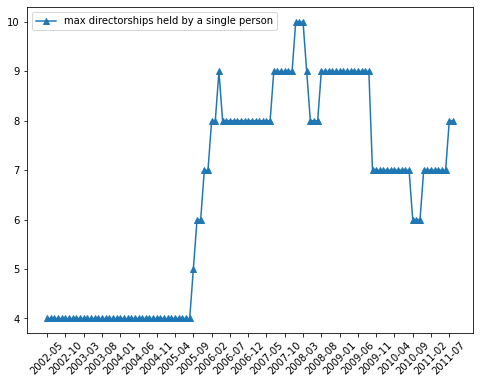

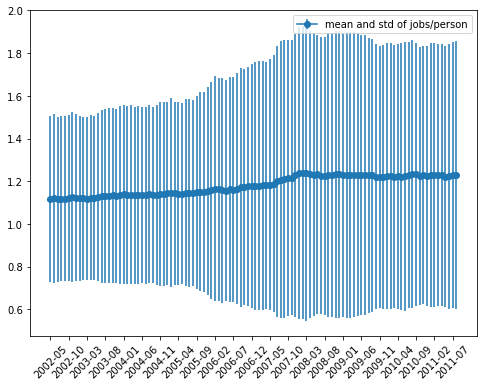

In [ ]:
gp = dg[dg['jobs']>=1].groupby('date')
mean_j = []
max_j = []
std_j = []
for d,group in gp:
  mean_j.append(np.mean(group['jobs']))
  std_j.append(np.std(group['jobs']))
  max_j.append(np.max(group['jobs']))
plt.figure(figsize=(8,6))
plt.plot(dates,max_j,marker='^')
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.legend(['max directorships held by a single person'])
plt.savefig(path+'max_jobs.png')
plt.show()

plt.figure(figsize=(8,6))
plt.errorbar(dates,mean_j,std_j,marker='o')
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.legend(['mean and std of jobs/person'])
plt.savefig(path+'mean_jobs.png')
plt.show()


In [ ]:
G = graphs[0]
enterprises = np.array([G.vertex_properties['enterprise'][u] for u in G.get_vertices()])
#u_enterprises = np.unique(enterprises)
['AKVA GROUP ASA'in e for e in enterprises]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 

# Women/men ratio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


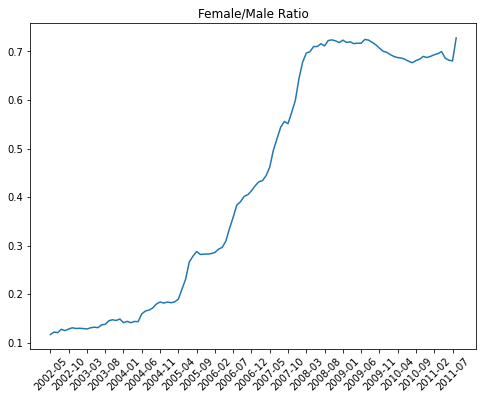

In [ ]:
ratio = []
ratio_dict = {}
ratio_dict['date'] = []
ratio_dict['values'] = []
u_enterprises = np.unique(companies['name'])
for d,G in zip(enumerate(dates),graphs):
  a = np.array([G.vertex_properties['genre'][u] for u in G.get_vertices()])
  enterprises = np.array([G.vertex_properties['enterprise'][u] for u in G.get_vertices()])
  values_by_enterprise = []
  for enterp in u_enterprises:
    filter = [enterp in k for k in enterprises]
    filtered = a[filter]
    male = np.where(filtered == 1)[0]
    female = np.where(filtered == 2)[0]
    try:
      values_by_enterprise.append(float(len(female))/len(male))
      ratio_dict['values'].extend(values_by_enterprise)
      ratio_dict['date'].extend([d[1]]*len(values_by_enterprise))
    except:
      pass
  ratio.append(np.mean(values_by_enterprise))
plt.figure(figsize=(8,6))
plt.plot(dates,ratio)
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.title('Female/Male Ratio')
plt.savefig(path+"sex_ratio.png")
plt.show()


In [ ]:
ratio[-1]

0.7278849662470351

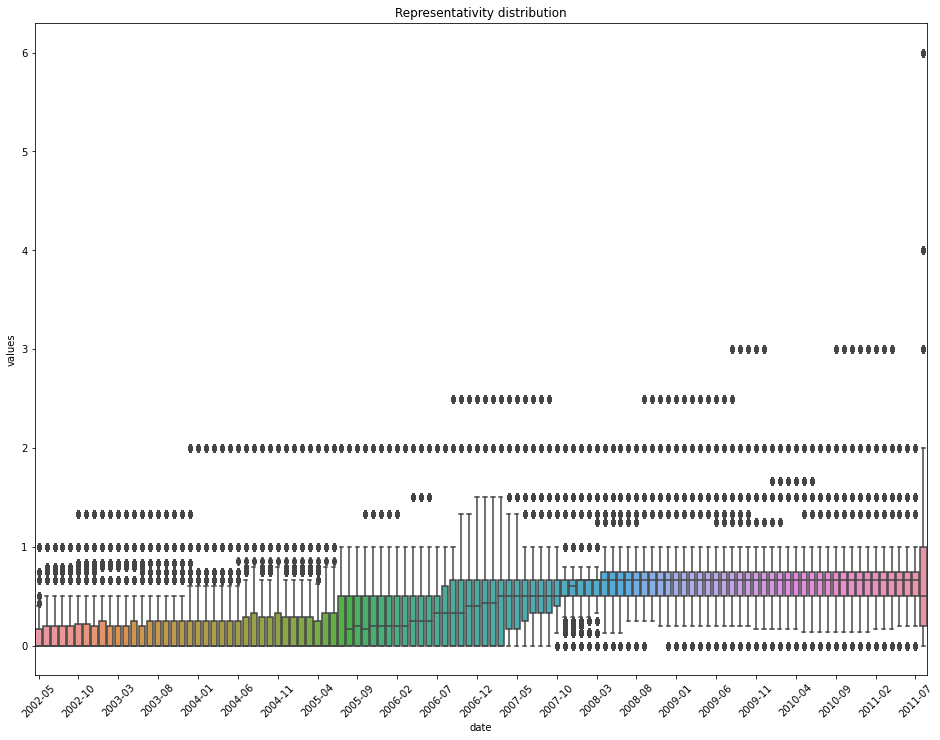

In [ ]:
plt.figure(figsize=(16,12))
ax = sns.boxplot(x='date',y='values',data=pd.DataFrame.from_dict(ratio_dict))
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
#plt.ylim(0,2)
plt.title("Representativity distribution")
plt.savefig(path+"representativity.png")

#Assortativity

In [ ]:
assort_degree = []
assort_genre = []
error_degree = []
error_genre = []
for graph in graphs:
  assort = assortativity(graph,"out")
  assort_degree.append(assort[0])
  error_degree.append(assort[1])
  assort = assortativity(graph,graph.vertex_properties['genre'])
  assort_genre.append(assort[0])
  error_genre.append(assort[1])

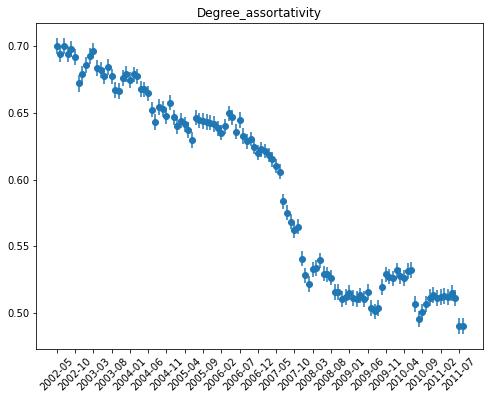

In [ ]:
plt.figure(figsize=(8,6))
plt.errorbar(dates,assort_degree,error_degree, linestyle='None', marker='o')
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.title('Degree_assortativity')
plt.savefig(path+"degree_assortativity.png")
plt.show()

Porque? Tendência de pessoas trabalharem em empresas de mesmo tamanho

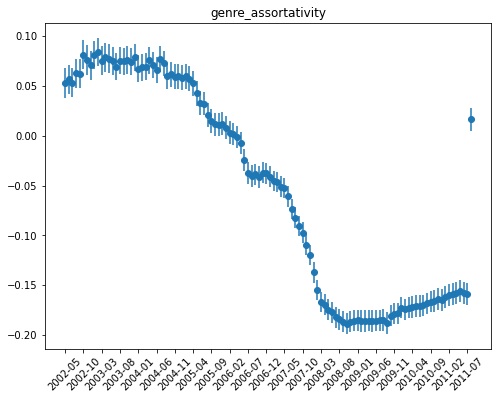

In [ ]:
plt.figure(figsize=(8,6))
plt.errorbar(dates,assort_genre,error_genre, linestyle='None', marker='o')
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.title('genre_assortativity')
plt.savefig(path+"genre_assortativity.png")
plt.show()

#Distributions

In [ ]:
def get_closeness(G):
  G.vertex_properties['closeness'] = G.new_vertex_property("double")
  c = closeness(G,vprop = G.vertex_properties['closeness'])
  if type(c) is tuple:
    c = c[0]
  return np.array(c.get_array())

In [ ]:
def get_betweenness(G):
  G.vertex_properties['betweenness'] = G.new_vertex_property("double")
  c = betweenness(G,vprop=G.vertex_properties['betweenness'])
  if type(c) is tuple:
    c = c[0]
  return np.array(c.get_array())

In [ ]:
def get_pagerank(G):
  G.vertex_properties['page_rank'] = G.new_vertex_property("double")
  c = pagerank(G,prop=G.vertex_properties['page_rank'])
  if type(c) is tuple:
    c = c[0]
  return np.array(c.get_array())


In [ ]:
def get_connected_components(G):
  # label the components in a property map
  c = label_components(G)[0]
  cc = list()
  total_components = int(np.max(c.get_array())) + 1
  for i in range(total_components):
    u = GraphView(G, vfilt=c.a == i)
    cc.append(len(u.get_vertices()))
  return cc

In [ ]:
def get_distance(G):
  #lengths = dict()
  lengths = list()
  #retorna um dicionário onde a chave é a distância e o valor quantas vezes 
  #ela se repete no grafo
  if G.is_directed():
    for u in G.get_vertices():
      for v in G.get_vertices():
        if v>u:
          dist = gt.topology.shortest_distance(G,u,v)
          if dist < len(G.get_vertices()):
            lengths.append(dist)
  else:
    for u in G.get_vertices():
      for v in G.get_vertices():
        if v>u:
          dist = gt.topology.shortest_distance(G,u,v)
          if dist < len(G.get_vertices()):
            lengths.append(dist)
  return lengths

In [ ]:
def get_metrics(G):
  metrics = dict()
  metrics['degree'] =  G.get_out_degrees(G.get_vertices())
  metrics['distance'] = get_distance(G)
  metrics['tam_CC'] = get_connected_components(G)
  metrics['betweenness'] = get_betweenness(G)
  metrics['closeness'] = get_closeness(G)
  return metrics

In [ ]:
def get_CCDF(metrics):
  total = len(metrics)
  relative_frequencies = dict()
  for i in metrics:
    if i in relative_frequencies:
      relative_frequencies[i] += 1/total
    else:
      relative_frequencies[i] = 1/total
  x = list()
  y = list()
  degrees = sorted(list(relative_frequencies.keys()))
  for k in degrees:
    fraction_up_to_K = 0
    for j in relative_frequencies.keys():
        if j < k:
          fraction_up_to_K += relative_frequencies[j]
    x.append(k)
    y.append(1 - fraction_up_to_K)
    #y.append(fraction_up_to_K)
  return x,y,relative_frequencies.values()

In [ ]:
data = {}
data['degree'] = []
data['page_rank'] = []
#data['distance']= []
data['betweenness']= []
data['closeness']= []
data['date'] = []

for d,G in zip(enumerate(dates),graphs):
   y = G.get_out_degrees(G.get_vertices())
   x = [d[1]]*len(y)
   data['degree'].extend(y)
   data['page_rank'].extend(get_pagerank(G))
   #data['distance'].extend(get_distance(G))
   data['betweenness'].extend(get_betweenness(G))
   data['closeness'].extend(get_closeness(G))
   data['date'].extend(x)
with open(path+"data.pickle","wb") as f:
    pickle.dump(data,f)
with open(path+"data.pickle","rb") as f:
    data = pickle.load(f)
dg = pd.DataFrame.from_dict(data)

In [ ]:
metrics = list(data.keys())
metrics.remove('date')

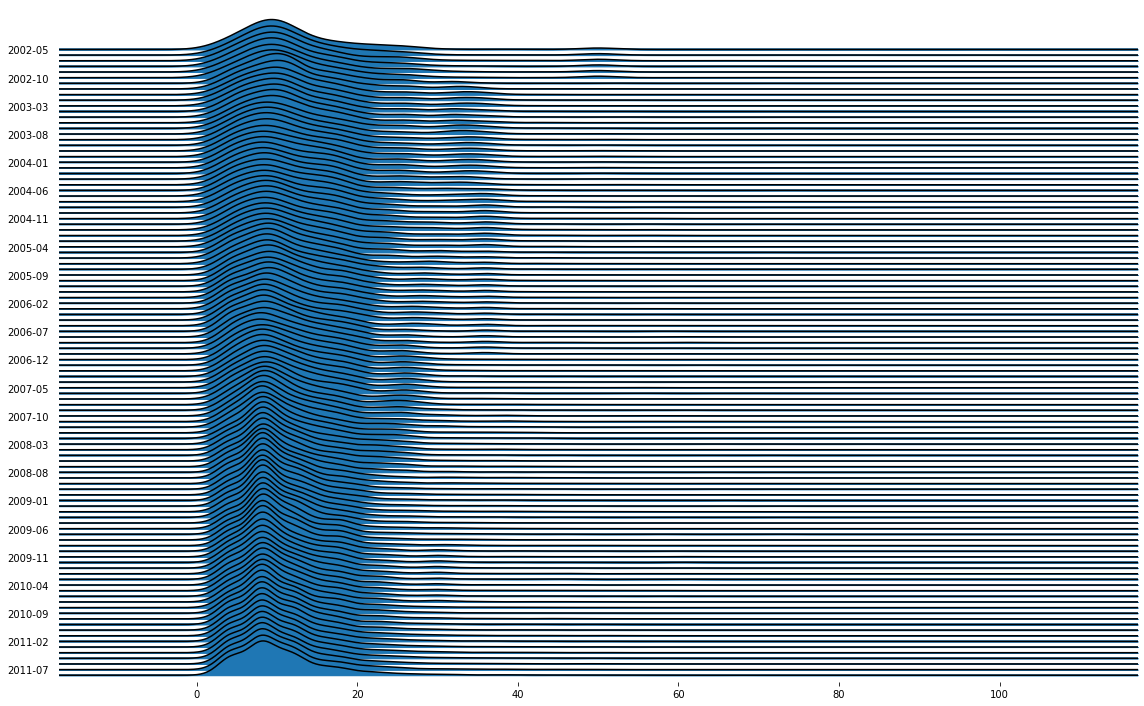

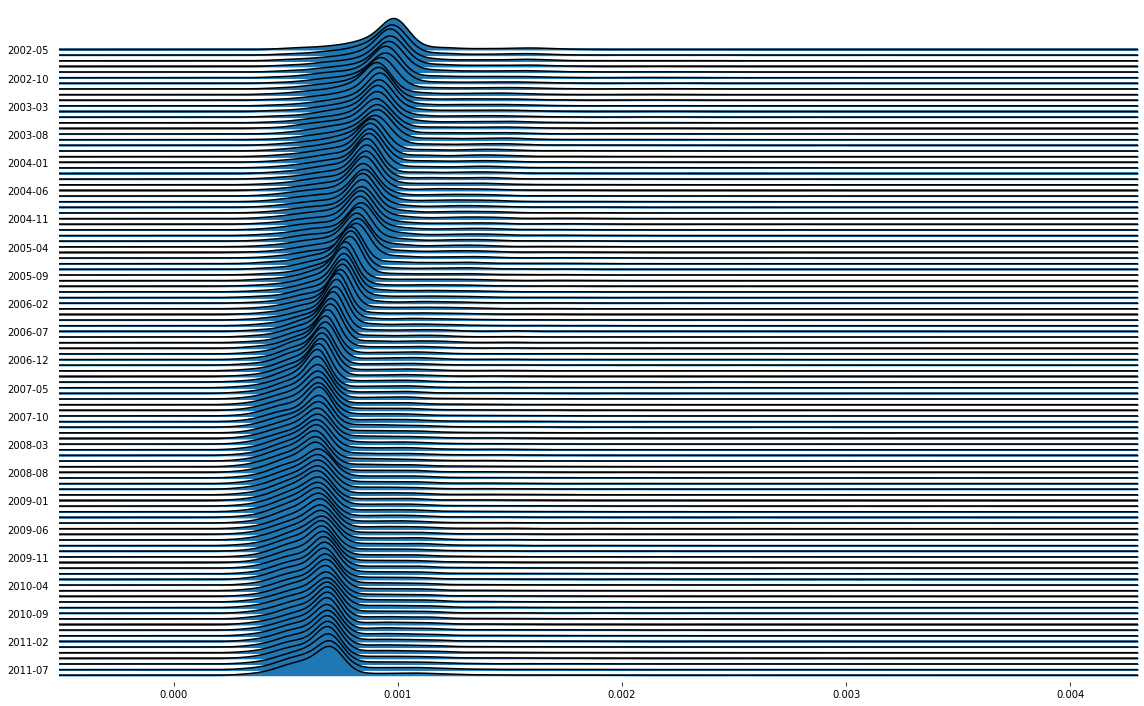

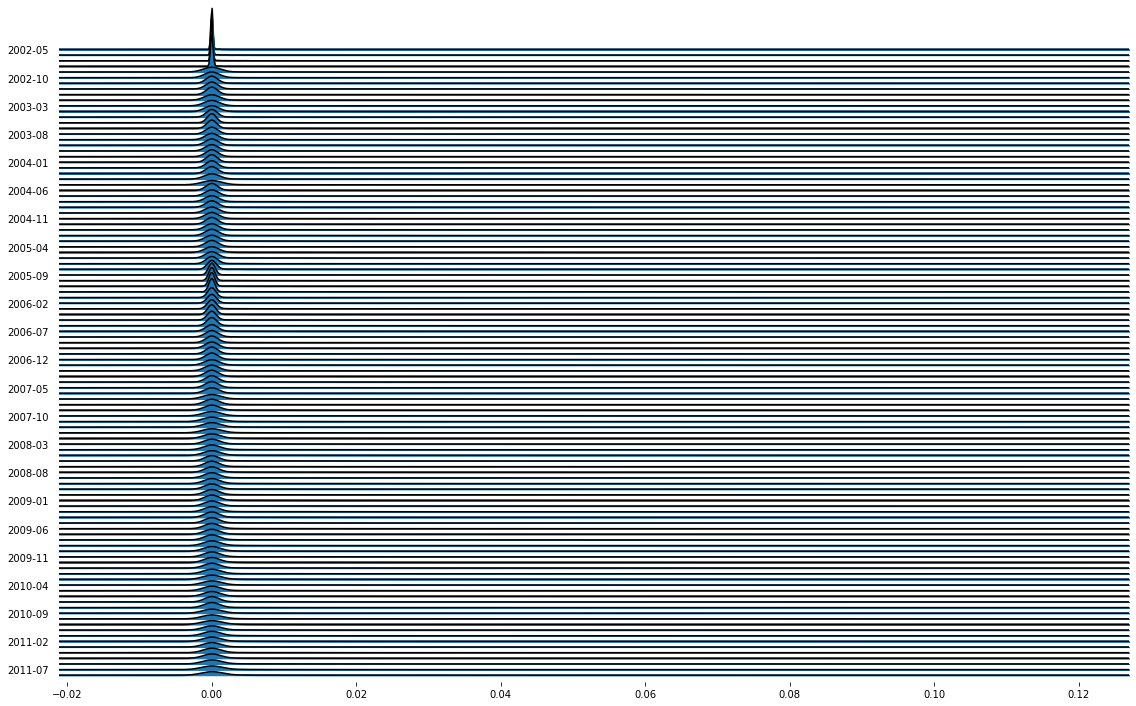

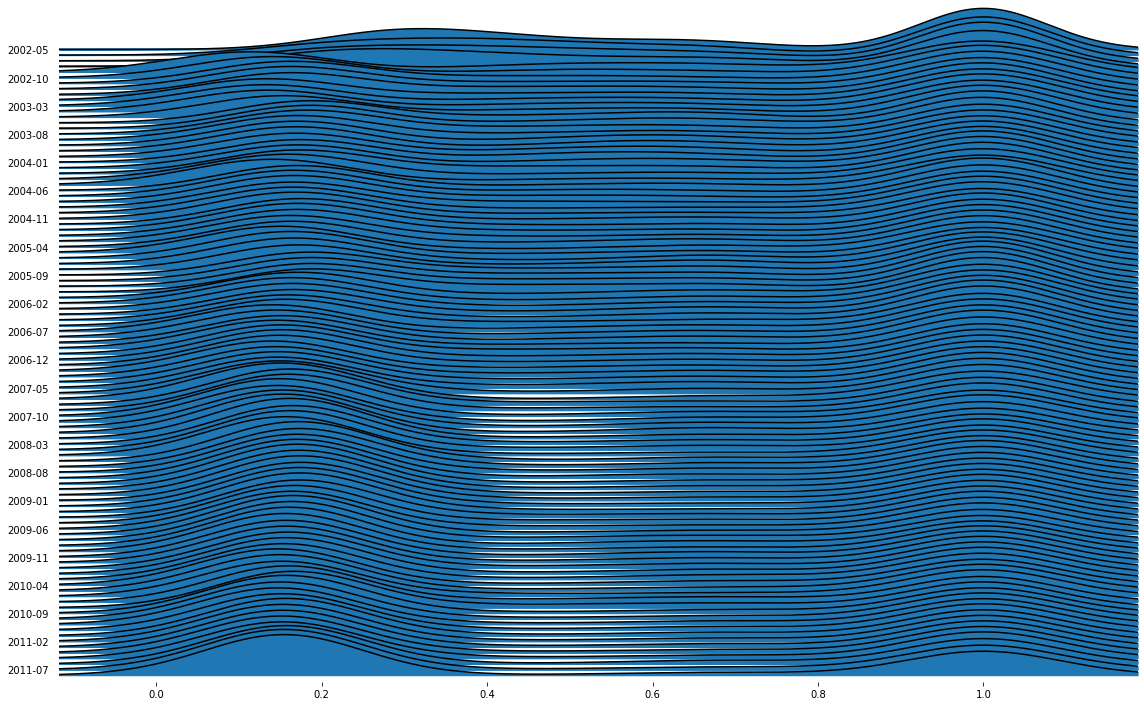

In [ ]:
for metric in metrics:
  fig, axes = joyplot(
      data=dg[['date',metric]], 
      by='date',
      figsize=(16,10),
      ylabels=True,
      bins = 100
  )
  for i,ax in enumerate(axes):
    #ax.set_xlim(xmin = dg[metric].min(),xmax = dg[metric].max())
    if i not in positions:
      ax.set_yticks([])
  #plt.title('Degree Distribution through Time')
  plt.savefig(path+metric+'_distribution.png')

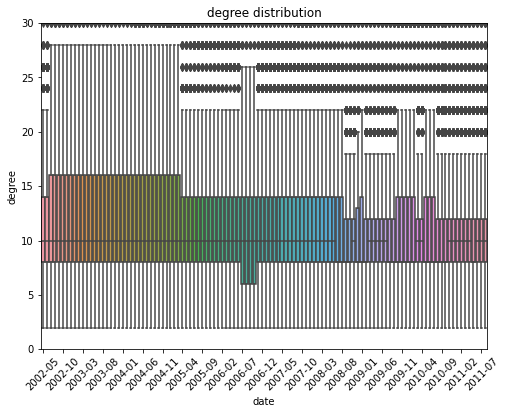

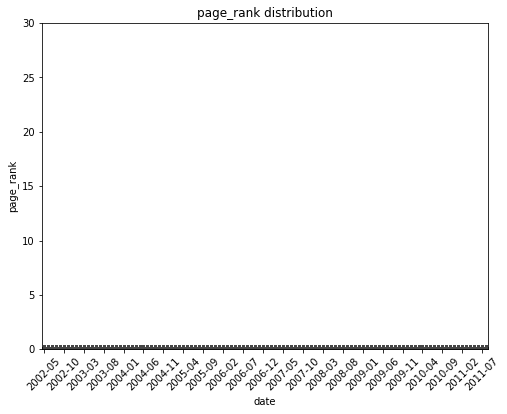

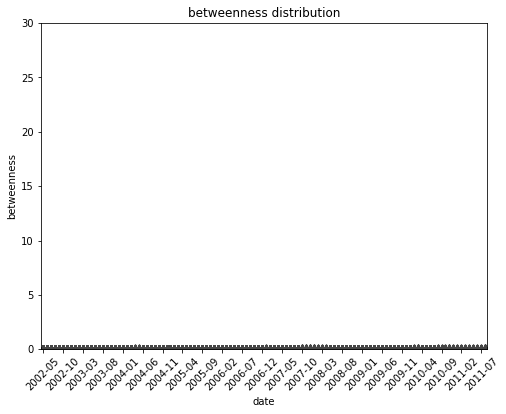

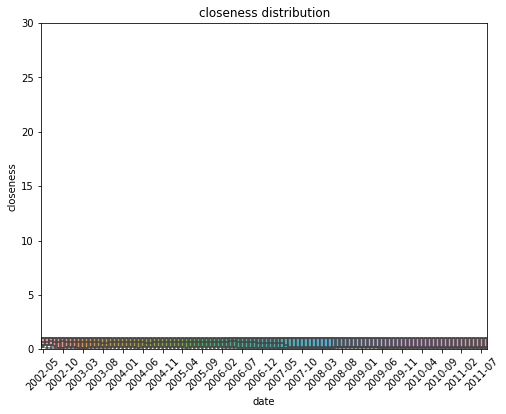

In [ ]:
for metric in metrics:
  plt.figure(figsize=(8,6))
  ax = sns.boxplot(x='date',y=metric,data=dg[['date',metric]])
  plt.xticks(positions,[dates[d] for d in positions], rotation=45)
  plt.title(metric+" distribution")
  plt.ylim(0,30)
  #plt.savefig(path+metric+'_distribution.png')

#Social Capital

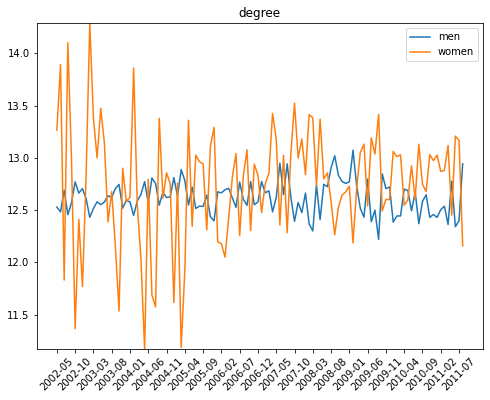

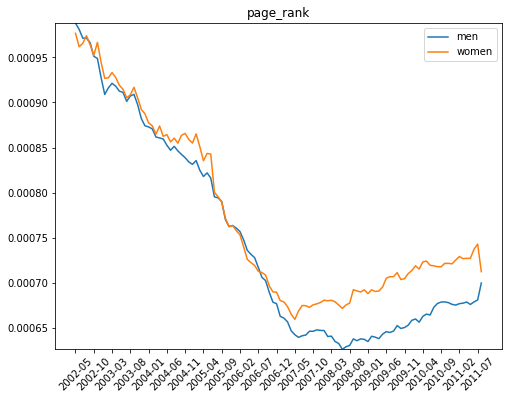

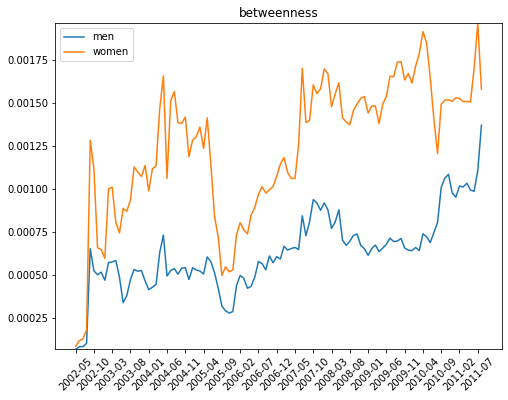

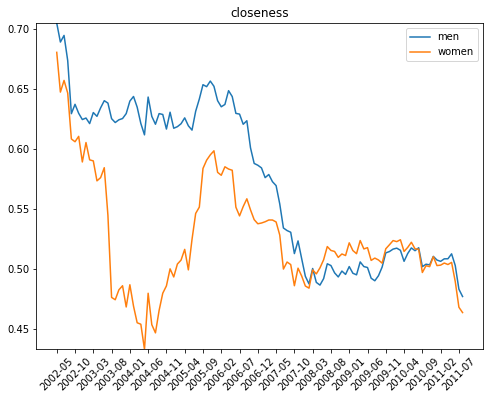

In [ ]:
for metric in metrics:
  male_metric = []
  female_metric = []
  for d,G in zip(enumerate(dates),graphs):
      a = np.array([G.vertex_properties['genre'][u] for u in G.get_vertices()])
      male = np.where(a == 1)[0]
      female = np.where(a == 2)[0]
      y = []
      if metric == 'degree':
        y = data['degree']
      else:
        y =  [G.vertex_properties[metric][u] for u in G.get_vertices()]
      #print(male)
      male_metric.append(np.mean(np.array(y)[male]))
      female_metric.append(np.mean(np.array(y)[female]))
  plt.figure(figsize=(8,6))
  plt.plot(dates,male_metric)
  plt.plot(dates,female_metric)
  plt.legend(['men','women'])
  plt.ylim(np.min([male_metric,female_metric]),np.max([male_metric,female_metric]))
  plt.xticks(positions,[dates[d] for d in positions], rotation=45)
  plt.title(metric)
  plt.savefig(path+metric+'.png')
  plt.show()


#2008 Crisis impacts?

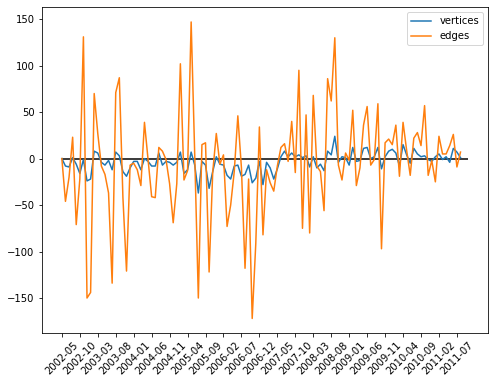

In [ ]:
 n_vertex = []
 n_edges = []
 for d,G in zip(enumerate(dates),graphs):
   n_vertex.append(len(list(G.get_vertices())))
   n_edges.append(len(list(G.get_edges()))/2)
n_vertex2 = list(n_vertex)
n_edges2 = list(n_edges)
n_vertex.insert(0,n_vertex[0])
n_edges.insert(0,n_edges[0])
n_vertex2.append(n_vertex2[-1])
n_edges2.append(n_edges2[-1])
n_vertex = np.array(n_vertex)
n_edges = np.array(n_edges)
n_vertex2 = np.array(n_vertex2)
n_edges2 = np.array(n_edges2)
plt.figure(figsize=(8,6))
plt.plot(dates,np.array(n_vertex - n_vertex2)[:-1])
plt.plot(dates,np.array(n_edges - n_edges2)[:-1])
plt.hlines(0,xmin=0,xmax=113)
plt.legend(['vertices','edges'])
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.savefig(path+'vertices_edges.png')

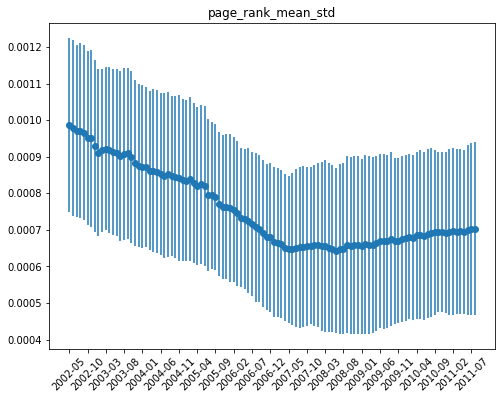

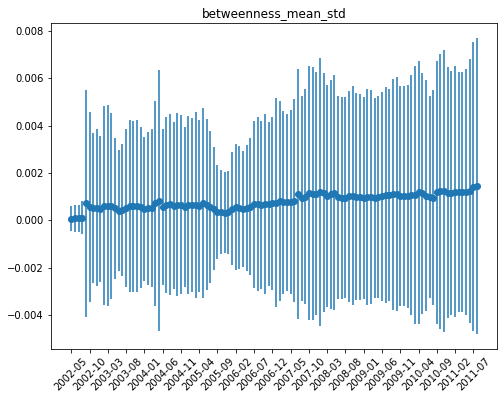

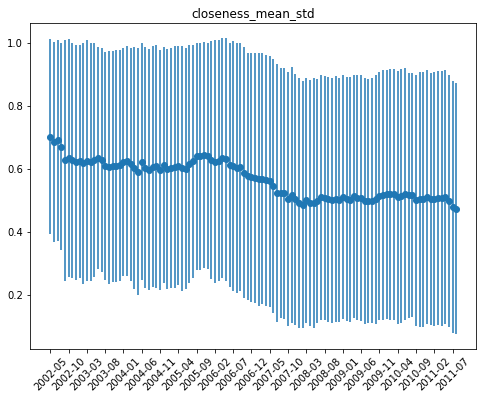

In [ ]:
for metric in metrics[1:]:
  y = []
  error = []
  for d,G in zip(enumerate(dates),graphs):
      m = [G.vertex_properties[metric][u] for u in G.get_vertices()]
      y.append(np.mean(m))
      error.append(np.std(m))
  plt.figure(figsize=(8,6))
  plt.errorbar(dates,y,error, linestyle='None', marker='o')
  plt.xticks(positions,[dates[d] for d in positions], rotation=45)
  plt.title(metric+'_mean_std')
  plt.savefig(path+metric+'_mean_variance.png')
  plt.show()

#Conected Components

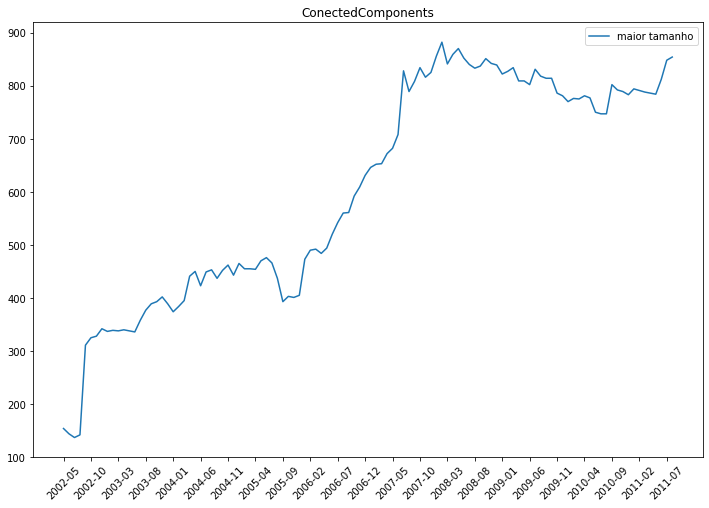

In [ ]:
n_cc = []
max_cc = []
for d,G in zip(enumerate(dates),graphs):
   y = get_connected_components(G)
   n_cc.append(len(y))
   max_cc.append(np.max(y))
plt.figure(figsize=(12,8))
plt.plot(dates,max_cc)
plt.legend(['maior tamanho'])
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.title('ConectedComponents')
plt.savefig(path+'ConectedComponents_max.png')
plt.show()

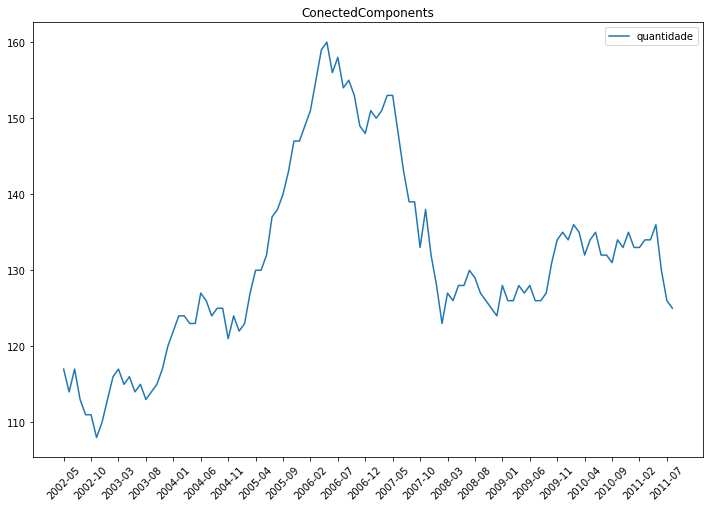

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(dates,n_cc)
plt.legend(['quantidade'])
plt.xticks(positions,[dates[d] for d in positions], rotation=45)
plt.title('ConectedComponents')
plt.savefig(path+'ConectedComponents_qtd.png')
plt.show()